In [12]:
%matplotlib inline

import datetime
import backtrader as bt
import pandas as pd
from matplotlib import pyplot as plt
from typing import List

from strategies import EWMAC_Indicator, EWMAC_Strategy
from ib_commission import IBCommission

In [6]:
data_feed = bt.feeds.YahooFinanceCSVData(
    dataname='./data/AAPL.csv',
    fromdate=datetime.datetime(2016, 1, 1),
    todate=datetime.datetime(2020, 12, 31),
)


In [13]:
def ewmac_demo(data_feed: bt.feeds.PandasData)->None:
    cerebro = bt.Cerebro()
    cerebro.addstrategy(EWMAC_Strategy, fast=32, slow=64)
    cerebro.adddata(data_feed)
    
    cerebro.broker.setcash(10000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.broker.addcommissioninfo(IBCommission())
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)

    results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

    plt.rcParams['figure.figsize'] = (16, 8)
    cerebro.plot(iplot=False)

Starting Portfolio Value: 10000.00
2017-01-09 BUY EXECUTED, 27.80
2018-11-23 SELL EXECUTED, 42.52
2019-04-03 BUY EXECUTED, 47.17
Final Portfolio Value: 20061.00
Sharpe Ratio:  0.06732986126526921


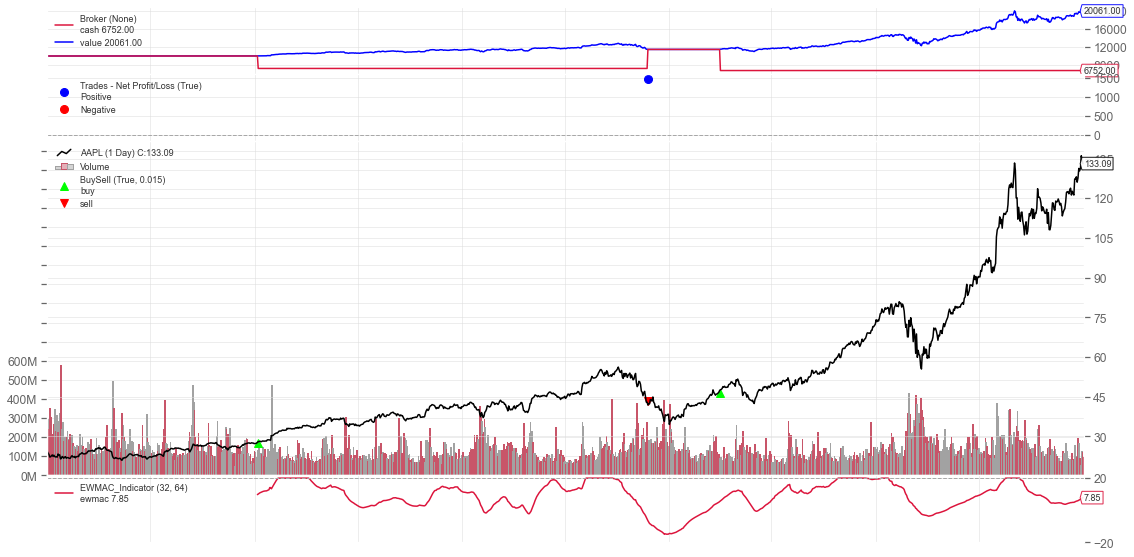

In [14]:
ewmac_demo(data_feed)

In [5]:
def optimizer(data_feed: bt.feeds.PandasData, fast: List[int], slow: List[int])->List[List[bt.cerebro.OptReturn]]:
    cerebro = bt.Cerebro()
    cerebro.optstrategy(EWMAC_Strategy, fast=fast, slow=slow)
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(10000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.broker.addcommissioninfo(IBCommission())
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
    cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    return cerebro.run()

In [6]:
def get_perf(optimize_runs: List[List[bt.cerebro.OptReturn]])->pd.DataFrame:
    stats = []
    for run in optimize_runs:
        for strategy in run:
            stats.append(
                {'strategy': f'EWMAC_{strategy.params.fast}_{strategy.params.slow}',
                'sharpe_ratio': strategy.analyzers.sharperatio.get_analysis()['sharperatio'],
                'return': '{0:.2f}%'.format(list(strategy.analyzers.timereturn.get_analysis().values())[0] * 100),
                'buy_and_hold': '{0:.2f}%'.format(list(strategy.analyzers.buyandhold.get_analysis().values())[0] * 100),
                'vwr': strategy.analyzers.vwr.get_analysis()['vwr'],
                }
            )
    df = pd.DataFrame(stats)
    df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)
    df.set_index('strategy', inplace=True)
    return df

In [13]:
fast = [16, 32]
slow = [x * 4 for x in fast]

results = optimizer(data_feed, fast, slow)

Starting Portfolio Value: 10000.00
2017-01-09 BUY EXECUTED, 27.80
2017-01-09 BUY EXECUTED, 27.80
2018-02-09 SELL EXECUTED, 37.762018-01-16 BUY EXECUTED, 42.60

2018-03-01 BUY EXECUTED, 42.93
2018-01-16 BUY EXECUTED, 42.60
2018-11-15 SELL EXECUTED, 45.79
2018-12-10 SELL EXECUTED, 40.102018-11-23 SELL EXECUTED, 42.52

2018-11-26 SELL EXECUTED, 42.35
2019-03-21 BUY EXECUTED, 46.38
2019-04-18 BUY EXECUTED, 49.582019-04-03 BUY EXECUTED, 47.17

2019-04-08 BUY EXECUTED, 47.94
2020-03-24 SELL EXECUTED, 58.45
2020-05-27 BUY EXECUTED, 78.39


In [14]:

get_perf(results)

,sharpe_ratio,return,buy_and_hold,vwr
strategy,,,,
EWMAC_32_64,0.067330,100.61%,462.51%,9.157730
EWMAC_16_64,0.056151,79.52%,462.51%,7.835035
EWMAC_16_128,0.054913,84.87%,462.51%,8.186470
EWMAC_32_128,0.051729,80.98%,462.51%,7.933412


In [11]:
fast = [4, 8]

results2 = optimizer(data_feed, fast, slow);

Starting Portfolio Value: 10000.00
2017-01-09 BUY EXECUTED, 27.80
2017-01-09 BUY EXECUTED, 27.80
2018-01-16 BUY EXECUTED, 42.602018-01-16 BUY EXECUTED, 42.60

2018-02-05 SELL EXECUTED, 38.102018-02-06 SELL EXECUTED, 37.07

2018-02-27 BUY EXECUTED, 43.062018-02-26 BUY EXECUTED, 42.40

2018-04-03 SELL EXECUTED, 40.31
2018-04-27 SELL EXECUTED, 39.43
2018-04-18 BUY EXECUTED, 42.75
2018-05-08 BUY EXECUTED, 44.48
2018-04-25 SELL EXECUTED, 39.10
2018-05-07 BUY EXECUTED, 44.52
2018-11-13 SELL EXECUTED, 46.58
2018-11-15 SELL EXECUTED, 45.79
2018-11-20 SELL EXECUTED, 43.35
2018-11-07 SELL EXECUTED, 49.89
2019-03-22 BUY EXECUTED, 47.68
2019-04-03 BUY EXECUTED, 47.17
2019-03-19 BUY EXECUTED, 45.97
2019-03-15 BUY EXECUTED, 45.12
2019-05-29 SELL EXECUTED, 43.23
2019-06-21 BUY EXECUTED, 48.71
2019-05-24 SELL EXECUTED, 44.15
2019-06-19 BUY EXECUTED, 48.93
2020-03-20 SELL EXECUTED, 61.122020-03-24 SELL EXECUTED, 58.45

2020-03-19 SELL EXECUTED, 61.18
2020-05-07 BUY EXECUTED, 74.982020-05-11 BUY EXECUTE

In [12]:
get_perf(results2)

,sharpe_ratio,return,buy_and_hold,vwr
strategy,,,,
EWMAC_4_64,0.058490,79.68%,462.51%,7.846225
EWMAC_4_128,0.051897,74.69%,462.51%,7.511990
EWMAC_8_64,0.050416,71.93%,462.51%,7.320872
EWMAC_8_128,0.047218,68.67%,462.51%,7.093647
